# Human Speech Emotion Classification

In [1]:
# Install Packages
!pip install librosa --upgrade --quiet
!pip install noisereduce --upgrade --quiet

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os
import opendatasets as od
import csv
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import seaborn as sns
import noisereduce as nr
from IPython.display import Audio
import librosa
import librosa.display
import wave
from numba import jit, cuda 
import torch

import scipy.stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, StratifiedKFold, train_test_split

import prjLib as lib

import warnings
warnings.filterwarnings ('ignore')

## Parameters

In [2]:
# Parameters

FRAME_LEN = 4096
HOP_LEN = 2048
N_MFCC = 14

DOWN_SR = 6000 # 22050
SECS = 3
MAX_FILES = 13000

ravdess = ['RAVDESS','data/ravdess-emotional-speech-audio']
tess = ['TESS','data/toronto-emotional-speech-set-tess']
cremad = ['CREMA-D','data/cremad/AudioWAV']
savee = ['SAVEE','data/savee-database/AudioData']
data_paths = [ravdess,tess,cremad,savee] # ravdess,tess,cremad,savee

GPU = torch.device('cuda')
CPU = torch.device('cpu')
DEVICE = GPU

In [4]:
def Numpy2Torch(arr):
    return torch.from_numpy(arr).to(DEVICE)

## Preprocessing

In [3]:
def ExtractLabel(audio_file_path,dataset_name):
    emotion = -1
    gender = 0
    if (dataset_name == 'RAVDESS'):
        emotion = int(audio_file_path[7:8]) - 1
        gender = int(audio_file_path[18:20]) & 0x1
    if (dataset_name == 'TESS'):
        if '_neutral' in audio_file_path:
            emotion = 0
        if '_happy' in audio_file_path:
            emotion = 2
        if '_sad' in audio_file_path:
            emotion = 3
        if '_angry' in audio_file_path:
            emotion = 4
        if '_fear' in audio_file_path:
            emotion = 5
        if '_disgust' in audio_file_path:
            emotion = 6
        if '_ps' in audio_file_path:
            emotion = 7
        if 'OAF_' in audio_file_path:
            gender = 1
        if 'YAF_' in audio_file_path:
            gender = 0
    if (dataset_name == 'CREMA-D'):
        if '_NEU_' in audio_file_path:
            emotion = 0
        if '_HAP_' in audio_file_path:
            emotion = 2
        if '_SAD_' in audio_file_path:
            emotion = 3
        if '_ANG_' in audio_file_path:
            emotion = 4
        if '_FEA_' in audio_file_path:
            emotion = 5
        if '_DIS_' in audio_file_path:
            emotion = 6
        speaker_id = int(audio_file_path[0:4])
        # df = pd.read_csv('data/cremad/VideoDemographics.csv')
        # df = df.loc[df['ActorID'] == speaker_id]
        # gender = int(df['Sex'] == 'Male')
    if (dataset_name == 'SAVEE'):
        if 'n' in audio_file_path:
            emotion = 0
        if 'h' in audio_file_path:
            emotion = 2
        if 'sa' in audio_file_path:
            emotion = 3
        if 'a' in audio_file_path:
            emotion = 4
        if 'f' in audio_file_path:
            emotion = 5
        if 'd' in audio_file_path:
            emotion = 6
        if 'su' in audio_file_path:
            emotion = 7
        gender = 1
    return emotion # np.concatenate(np.array([emotion,gender]).reshape(1,2),axis=0)

In [4]:
# Collect Data from audio files
ii=0
sample_data = np.zeros([MAX_FILES,SECS*2*DOWN_SR],dtype=np.float32)  # stores the features
labels = np.zeros([MAX_FILES,1],dtype=np.int8)  # stores the labels
for data_path in tqdm(data_paths,desc="Collecting Datasets"):
    root_dir = data_path[1]
    cpt = sum([len(d) for r, d, files in os.walk(root_dir)])+1
    for subdirs, dirs, files in tqdm(os.walk(root_dir), total=cpt, desc=f'Processing {data_path[0]} audio files', unit="file"):
        for file in files:
            if not '.wav' in file:
                continue
            audio_file_path = os.path.join(subdirs, file)
            sample, sr = librosa.load(audio_file_path,sr=DOWN_SR)
            sample = nr.reduce_noise(y=sample, sr=sr)
            if not np.isfinite(sample).all():
                continue
            sample, index = librosa.effects.trim(sample)
            sample_data[ii,:] = lib.FixSamples(sample,DOWN_SR,SECS)
            labels[ii,:] = ExtractLabel(file,data_path[0])
            ii += 1
sample_data = sample_data[:ii,:]
labels = labels[:ii,:]
print(f'Data with total {sample_data.shape[0]} audio samples collected, with {sample_data.shape[1]} samples each.')

MemoryError: Unable to allocate 1.74 GiB for an array with shape (13000, 36000) and data type float32

In [7]:
#sample_data = lib.Numpy2Pandas(sample_data)
labels = pd.DataFrame(labels, columns=['Emotion'])
labels['Emotion'].replace({0:0, 1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:1}, inplace=True)
labels = labels.to_numpy()
#sample_data = Numpy2Torch(sample_data)

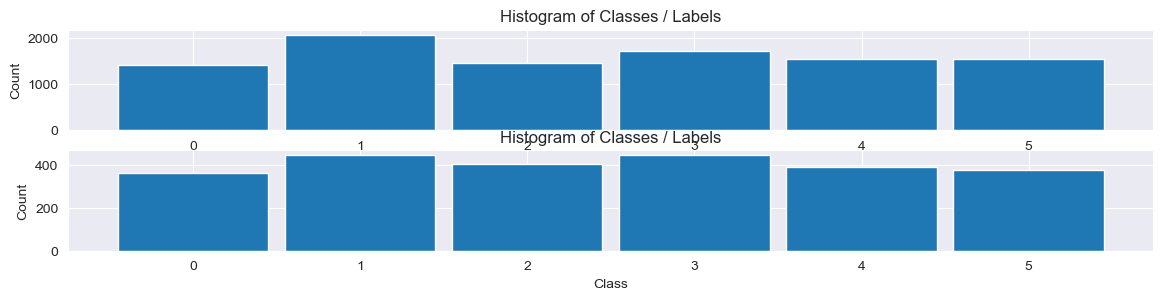

In [8]:
# Data samples split
train_data, test_data, train_labels, test_labels = train_test_split(sample_data, labels, train_size = 0.8, random_state = 512)
#train_labels.reset_index(drop=True,inplace=True)
#test_labels.reset_index(drop=True,inplace=True)
lib.PlotSplitedDataHistogram(train_labels, test_labels)

## Augmentation

In [9]:
def Noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def TimeShift(data):
    shift_range = int(np.random.uniform(-5,5)*1000)
    return np.roll(data, shift_range)

def TimeStretch(data):
    stretch_factor = np.random.uniform(0.5,2)
    return librosa.effects.time_stretch(y=data, rate=stretch_factor)

def PitchScale(data,sr):
    pitch_factor = np.random.uniform(0.5,2)
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=pitch_factor)

def InvertPolarity(data):
    return data * -1

def RandomGain(data):
    gain = np.random.uniform(0.2,1.5)
    return data * gain

def CreateAugmentedData(data,sr):
    data = TimeStretch(data)
    data = lib.FixSamples(data,DOWN_SR,SECS)
    data = PitchScale(data,sr)
    data = TimeShift(data)
    data = Noise(data)
    data = RandomGain(data)
    data = InvertPolarity(data)
    return data

# Time masking
# Frequency masking

In [10]:
def AddAugmentionOnDataCollection(data,sr):
    data_with_augm = np.zeros([data.shape[0]*2,data.shape[1]],dtype=np.float32)
    for ii in tqdm(range(data.shape[0]), desc=f'Add augmentation data to audio samples'):
        augmented_data = CreateAugmentedData(data[ii,:],sr)
        data_with_augm[ii,:] = data[ii,:]
        data_with_augm[ii+data.shape[0],:] = augmented_data
    return data_with_augm

train_data = AddAugmentionOnDataCollection(train_data,DOWN_SR)
print(f'Train data added with Augmentation, shape = ({train_data.shape[0]},{train_data.shape[1]}).')

Add augmentation data to audio samples:   0%|          | 0/9728 [00:00<?, ?it/s]

Train data added with Augmentation, shape = (19456,36000).


In [11]:
def AddLabelsForAugmentedDataCollection(labels):
    labels_with_augm = np.zeros([labels.shape[0]*2,labels.shape[1]],dtype=np.int8)
    for ii in tqdm(range(labels.shape[0]), desc=f'Add Labels for augmentation data'):
        labels_with_augm[ii,:] = labels[ii,:]
        labels_with_augm[ii+labels.shape[0],:] = labels[ii,:]
    return labels_with_augm

train_labels = AddLabelsForAugmentedDataCollection(train_labels)
print(f'Train label added with Augmentation, shape = ({train_labels.shape[0]},{train_labels.shape[1]}).')

Add Labels for augmentation data:   0%|          | 0/9728 [00:00<?, ?it/s]

Train label added with Augmentation, shape = (19456,1).


## Feature Extraction

In [12]:
def extract_mvs(feature):
    features = np.array([])
    Mean = np.mean(feature,axis=0)
    #Var = np.var(feature,axis=0)
    #Sum = np.sum(feature,axis=0)
    Min = np.min(feature,axis=0)
    Max = np.max(feature,axis=0)
    #ArgMax = np.argmax(feature,axis=0)
    #MaxMeanRatio = Max / Mean
    #ArgMaxArgsRatio = ArgMax / feature.shape[1]
    features = np.hstack((features, Mean, Min, Max)) # , Var, Sum, Max, ArgMax, MaxMeanRatio, ArgMaxArgsRatio
    return features

In [13]:
def ExtractDeltasMvs(feature):
    features = np.array([])
    d_feature = librosa.feature.delta(feature)
    dd_feature = librosa.feature.delta(d_feature)
    features = np.hstack((features, extract_mvs(feature.T), extract_mvs(d_feature.T), extract_mvs(dd_feature.T)))
    return features

In [14]:
def ExtractFeatures(sample,sr):
    features = np.array([])
    # tempogram
    oenv = librosa.onset.onset_strength(y=sample, sr=sr, hop_length=508)
    prior_lognorm = scipy.stats.lognorm(loc=np.log(120), scale=120, s=1)
    dtempo_lognorm = extract_mvs(librosa.feature.tempo(onset_envelope=oenv, sr=sr,aggregate=None,prior=prior_lognorm))
    tempogram = extract_mvs(librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr,hop_length=508,win_length=51))
    ac_tempogram = extract_mvs(librosa.feature.tempogram(onset_envelope=oenv, sr=sr,hop_length=508,win_length=51,norm=None))
    tempogram_ratio = extract_mvs(librosa.feature.tempogram_ratio(y=sample,hop_length=508,win_length=51)) # Best score: 0.47143444307439375 (params: {'hop_len': 508, 'win_len': 51})
    features = np.hstack((features, dtempo_lognorm, tempogram, ac_tempogram, tempogram_ratio))
    # zcr
    zcr = extract_mvs(librosa.feature.zero_crossing_rate(y=sample, frame_length=3280, hop_length=469)) # Best score: 0.35511713933415534 (params: {'frame_len': 3280, 'hop_len': 469})
    features = np.hstack((features, zcr))
    # rms
    rms = extract_mvs(librosa.feature.rms(y=sample, frame_length=2988, hop_length=2503)) # Best score: 0.3670365803534731 (params: {'frame_len': 2988, 'hop_len': 2503})
    features = np.hstack((features, rms))
    # chroma
    chroma_stft = extract_mvs(librosa.feature.chroma_stft(y=sample, sr=sr , n_fft=199, win_length=46, hop_length=37,n_chroma=89)) # Best score: 0.5063707357172216 (params: {'n_fft': 199, 'hop_len': 37, 'win_len': 46, 'n_chroma': 89})
    #chroma_cqt = extract_mvs(librosa.feature.chroma_cqt(y=sample, sr=sr, hop_length=37, n_chroma=16,n_octaves=8, bins_per_octave=32))
    #chroma_cens = extract_mvs(librosa.feature.chroma_cens(y=sample, sr=sr, hop_length=37))
    #chroma_vq = extract_mvs(librosa.feature.chroma_vqt(y=sample, sr=sr,intervals='ji5',bins_per_octave=89))
    features = np.hstack((features, chroma_stft)) # chroma_cqt, chroma_cens, chroma_vq
    # mfcc
    melspectrogram = extract_mvs(librosa.feature.melspectrogram(y=sample, sr=sr , n_fft=FRAME_LEN, win_length=FRAME_LEN, hop_length=HOP_LEN))
    mfcc = extract_mvs(librosa.feature.mfcc(y=sample, sr=sr , n_mfcc=128, n_fft=886, win_length=886, hop_length=168))
    features = np.hstack((features, melspectrogram, mfcc))
    # spectral
    spectral_centroid = extract_mvs(librosa.feature.spectral_centroid(y=sample, n_fft=902, win_length=313, hop_length=509)) # Best score: 0.35018495684340323 (params: {'n_fft': 902, 'hop_len': 509, 'win_len': 313})
    spectral_bandwidth = extract_mvs(librosa.feature.spectral_bandwidth(y=sample, n_fft=723, win_length=84, hop_length=11)) # Best score: 0.292642827784628 (params: {'n_fft': 723, 'hop_len': 11, 'win_len': 84})
    spectral_contrast = extract_mvs(librosa.feature.spectral_contrast(y=sample, n_fft=902, win_length=313, hop_length=509))
    spectral_flatness = extract_mvs(librosa.feature.spectral_flatness(y=sample, n_fft=849, win_length=199, hop_length=311)) # Best score: 0.31607069461570075 (params: {'n_fft': 849, 'hop_len': 311, 'win_len': 199})
    spectral_rolloff = extract_mvs(librosa.feature.spectral_rolloff(y=sample, n_fft=902, win_length=313, hop_length=509)) # {'n_fft': 5501, 'hop_len': 212, 'win_len': 3126}
    features = np.hstack((features, spectral_centroid, spectral_bandwidth, spectral_contrast, spectral_flatness, spectral_rolloff))
    # poly_features
    poly_features = extract_mvs(librosa.feature.poly_features(y=sample, n_fft=174, win_length=173, hop_length=174)) # {'n_fft': 174, 'hop_len': 174, 'win_len': 173}
    features = np.hstack((features, poly_features))
    # tonnetz
    tonnetz = extract_mvs(librosa.feature.tonnetz(y=librosa.effects.harmonic(y=sample)))
    features = np.hstack((features, tonnetz))
    return features

In [20]:
def ExtractFeatures_MFCC(sample,sr):
    mfcc = librosa.feature.mfcc(y=sample, sr=sr , n_mfcc=128, n_fft=886, win_length=886, hop_length=168)
    mfcc_mean = np.mean(mfcc,axis=1)
    mfcc_min = np.min(mfcc,axis=1)
    mfcc_max = np.max(mfcc,axis=1)
    features = np.concatenate((mfcc_mean, mfcc_min, mfcc_max),axis=0)
    return features

In [36]:
def ExtractFeatures_Test(sample,sr,n_fft,frame_len,hop_len,win_len):
    feature = librosa.feature.melspectrogram(y=sample, n_fft=n_fft, win_length=win_len, hop_length=hop_len)
    feature_mean = np.mean(feature,axis=1)
    feature_min = np.min(feature,axis=1)
    feature_max = np.max(feature,axis=1)
    features = np.concatenate((feature_mean, feature_min, feature_max),axis=0)
    return features

In [21]:
def ExtractFeaturesOnDataCollection(data,sr):
    # data = data.to_numpy()
    features = ExtractFeatures_MFCC(data[0,:],sr)
    featured_data = np.zeros([data.shape[0],len(features)],dtype=np.float32)
    for ii in tqdm(range(data.shape[0]), desc=f'Extracting Features from audio samples'):
        featured_data[ii,:] = ExtractFeatures_MFCC(data[ii,:],sr)
    return featured_data

In [22]:
test_features = ExtractFeaturesOnDataCollection(test_data,DOWN_SR)
print(f'Test data with {test_features.shape[0]} samples and {test_features.shape[1]} features.')

Extracting Features from audio samples:   0%|          | 0/2433 [00:00<?, ?it/s]

Test data with 2433 samples and 384 features.


In [23]:
train_features = ExtractFeaturesOnDataCollection(train_data,DOWN_SR)
print(f'Train data with {train_features.shape[0]} samples and {train_features.shape[1]} features.')

Extracting Features from audio samples:   0%|          | 0/19456 [00:00<?, ?it/s]

Train data with 19456 samples and 384 features.


In [24]:
def Normalize(train_data,test_data):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    #train_data = lib.Numpy2Pandas(train_data)
    #test_data = lib.Numpy2Pandas(test_data)
    return train_data,test_data

def tScaler(data):
    m = data.mean(0, keepdim=True)
    s = data.std(0, unbiased=False, keepdim=True)
    data -= m
    data /= s
    return data

train_features_norm,test_features_norm = Normalize(train_features,test_features)
#train_data,test_data = Normalize(train_data,test_data)
#train_data = tScaler(train_data)
#test_data = tScaler(test_data)

#train_features = train_features.astype(np.float64)
#test_features = test_features.astype(np.float64)

## Train Model

Prediction Train Accuracy: 99.98 %
Prediction Test Accuracy: 59.39 %
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       363
           1       0.56      0.67      0.61       448
           2       0.55      0.66      0.60       405
           3       0.67      0.76      0.71       447
           4       0.67      0.35      0.46       391
           5       0.54      0.44      0.48       379

    accuracy                           0.59      2433
   macro avg       0.60      0.59      0.58      2433
weighted avg       0.60      0.59      0.59      2433



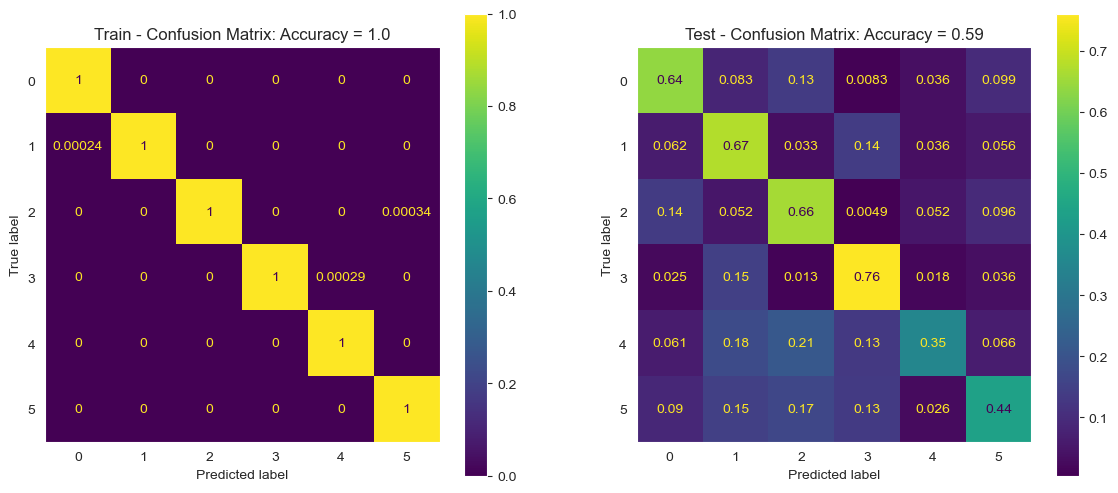

In [25]:
report, score, model = lib.TestClassificationModel(train_features_norm,train_labels,test_features_norm,test_labels,3, paramC=1,kernelType='rbf',n_estimators=100,min_samples_split=6,random_state=1, plot=True)

## Features Selection

<BarContainer object of 384 artists>

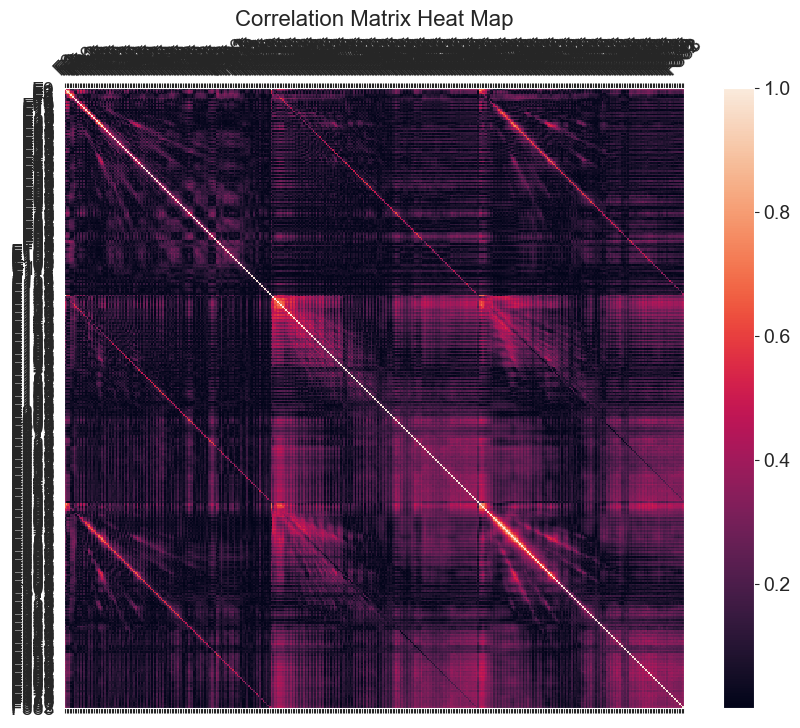

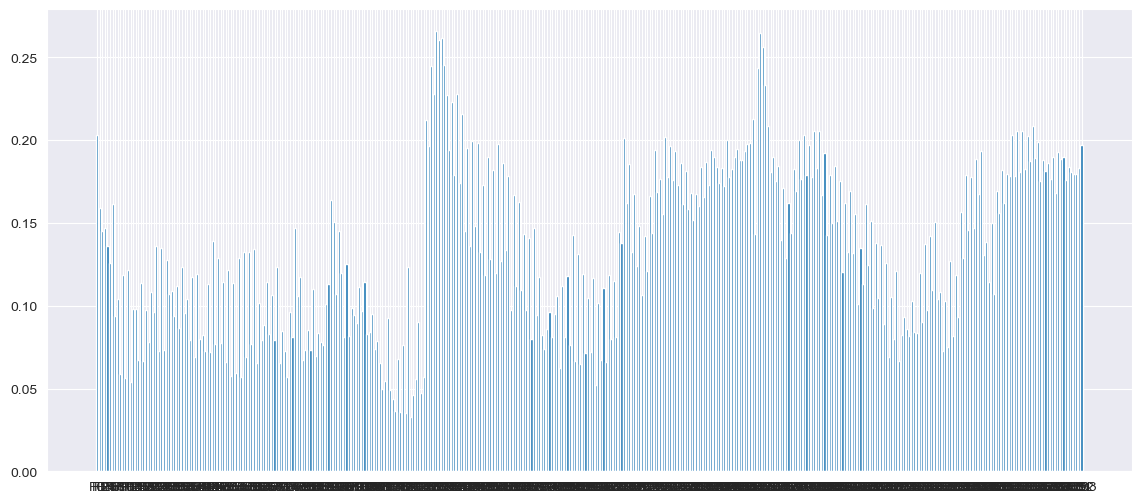

In [26]:
pd_train_features = lib.Numpy2Pandas(train_features)
corr_mat = lib.PlotCorrMap(pd_train_features)
corr_vec = lib.GetFeaturesCorr(corr_mat)

plt.figure(figsize=(14, 6))
plt.bar(x = corr_vec.columns, height = corr_vec.to_numpy()[0])

#lib.PlotPairAllFeature(train_data,train_labels,train_data.shape[1])

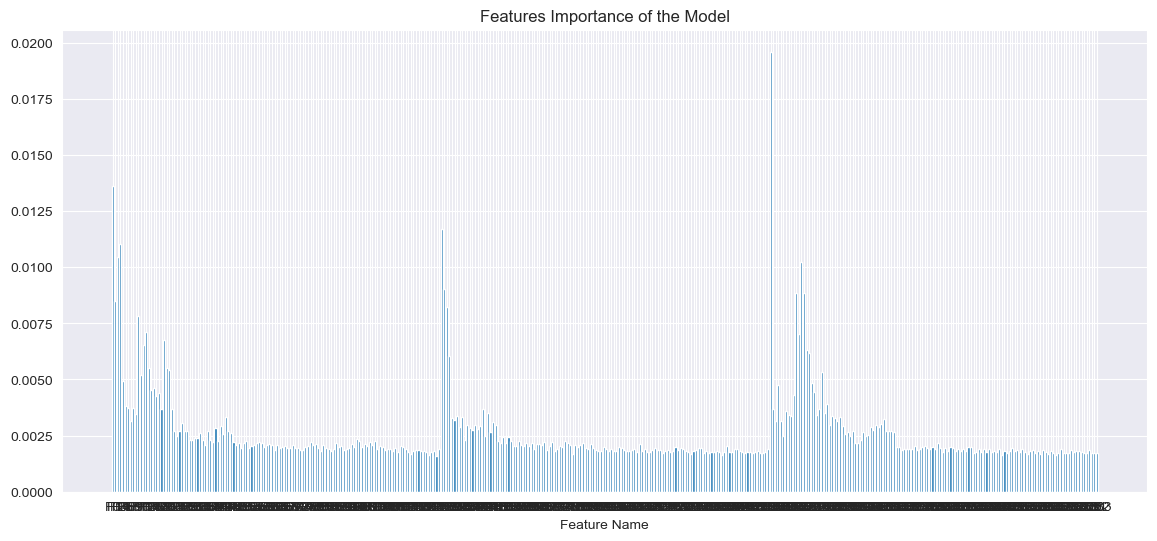

In [27]:
feature_importance = lib.FeaturesImportance(model,train_features)

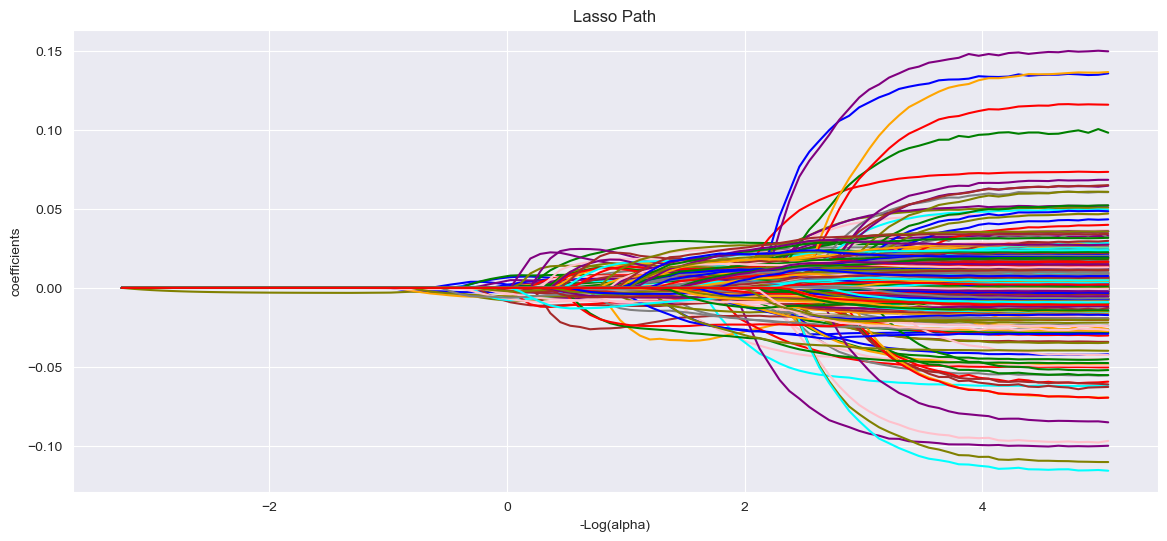

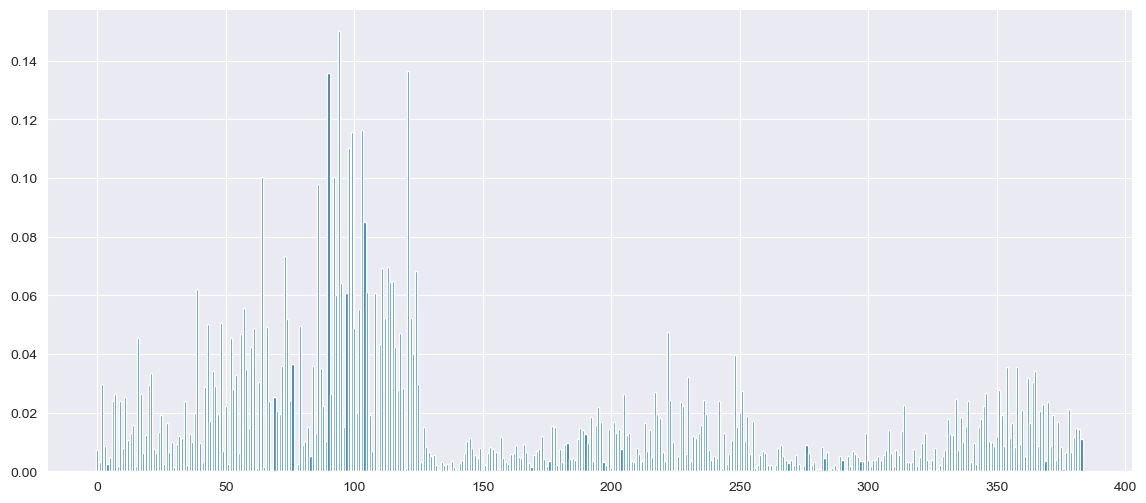

In [29]:
lasso_max = lib.PlotLassoElasticNetPaths(train_features,train_labels,eps=5e-9)

## Train with selected features

In [30]:
def TrainModel(train_data,train_labels,test_data,test_labels):
    oModel = RandomForestClassifier(n_estimators=100,min_samples_split=6,random_state=1,n_jobs=-1)
    oModel.fit(train_data,train_labels)
    accuracy = oModel.score(test_data,test_labels)
    return accuracy

In [31]:
def FeaturesSelect(train_features,test_features,features,features_threshold):
    weak_features_indexes = np.where(features < features_threshold)[0]
    train_features_selected = np.delete(train_features,weak_features_indexes,axis=1)
    test_features_selected = np.delete(test_features,weak_features_indexes,axis=1)
    n_feat = train_features_selected.shape[1]
    return train_features_selected,test_features_selected,n_feat

In [32]:
def TestByCorrThreshold(threshold):
    # Remove weak features
    train_features_selected,test_features_selected,n_feat = FeaturesSelect(train_features,test_features,corr_vec.to_numpy()[0,:],threshold)
    # Test selected features
    accuracy = TrainModel(train_features_selected,train_labels,test_features_selected,test_labels)
    return accuracy, n_feat

def TestByFeatureImportanceThreshold(threshold):
    # Remove weak features
    train_features_selected,test_features_selected,n_feat = FeaturesSelect(train_features,test_features,feature_importance,threshold)
    # Test selected features
    accuracy = TrainModel(train_features_selected,train_labels,test_features_selected,test_labels)
    return accuracy, n_feat

def TestByLassoThreshold(threshold):
    # Remove weak features
    train_features_selected,test_features_selected,n_feat = FeaturesSelect(train_features,test_features,lasso_max,threshold)
    # Test selected features
    accuracy = TrainModel(train_features_selected,train_labels,test_features_selected,test_labels)
    return accuracy, n_feat

In [33]:
def oFeatureImportanceThreshold(trial):
    feature_importance_threshold = trial.suggest_float("thr", 0, np.max(feature_importance)-1e-12)
    score, n_feat = TestByFeatureImportanceThreshold(feature_importance_threshold)
    return score

study_name="FeatureImportanceThreshold_4"
study = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{study_name}.db",  # Specify the storage URL here.
    direction='maximize'
)

study.optimize(oFeatureImportanceThreshold, n_trials=100)
score, n_feat = TestByFeatureImportanceThreshold(study.best_params['thr'])

print(f"Best score: {score} (n_feat: {n_feat}, threshold: {study.best_params})")

[I 2024-05-03 13:43:18,638] A new study created in RDB with name: FeatureImportanceThreshold_4
[I 2024-05-03 13:43:19,938] Trial 0 finished with value: 0.2531853678586108 and parameters: {'thr': 0.013805172643068018}. Best is trial 0 with value: 0.2531853678586108.
[I 2024-05-03 13:43:22,596] Trial 1 finished with value: 0.6050143855322647 and parameters: {'thr': 0.005356766378589886}. Best is trial 1 with value: 0.6050143855322647.
[I 2024-05-03 13:43:33,510] Trial 2 finished with value: 0.5939169749280724 and parameters: {'thr': 0.00012856536744351076}. Best is trial 1 with value: 0.6050143855322647.
[I 2024-05-03 13:43:44,786] Trial 3 finished with value: 0.6062474311549527 and parameters: {'thr': 0.0016254571425353174}. Best is trial 3 with value: 0.6062474311549527.
[I 2024-05-03 13:43:46,175] Trial 4 finished with value: 0.2531853678586108 and parameters: {'thr': 0.01445452681875552}. Best is trial 3 with value: 0.6062474311549527.
[I 2024-05-03 13:43:47,832] Trial 5 finished wit

Best score: 0.6235100698725853 (n_feat: 100, threshold: {'thr': 0.0025390645502191248})


(19456, 100)

(2433, 100)

Prediction Train Accuracy: 99.98 %
Prediction Test Accuracy: 62.27 %
              precision    recall  f1-score   support

           0       0.61      0.68      0.64       363
           1       0.59      0.67      0.63       448
           2       0.60      0.66      0.63       405
           3       0.69      0.79      0.74       447
           4       0.71      0.41      0.52       391
           5       0.55      0.50      0.52       379

    accuracy                           0.62      2433
   macro avg       0.63      0.62      0.61      2433
weighted avg       0.63      0.62      0.62      2433



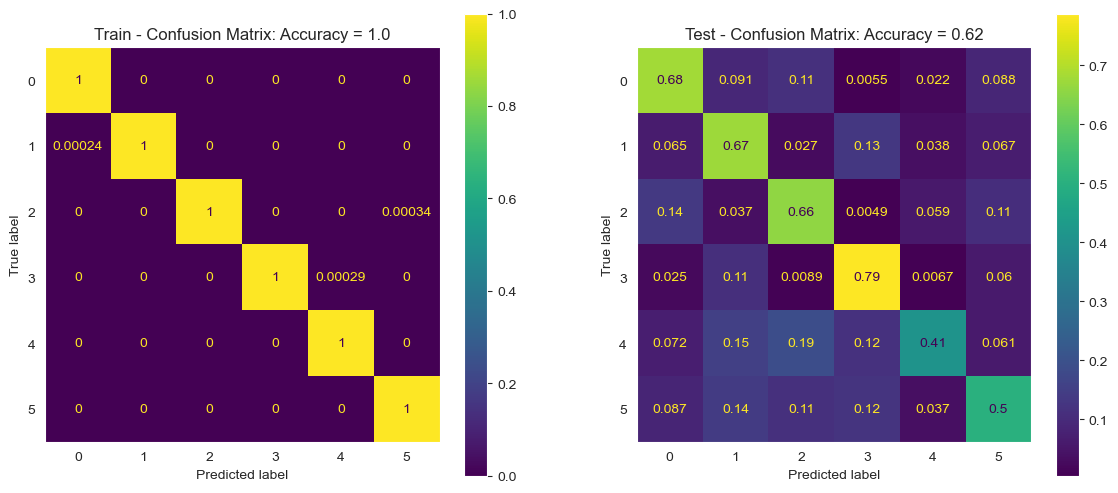

In [38]:
#important_features_indexes = np.where(feature_importance >= study.best_params['thr'])[0]

# Remove weak features
train_features_selected,test_features_selected,n_feat = FeaturesSelect(train_features,test_features,feature_importance,study.best_params['thr'])
display(train_features_selected.shape)
display(test_features_selected.shape)

# Normalize selected features
# train_features_norm,test_features_norm = Normalize(train_features_selected,test_features_selected)

# Test selected features
report, score, model = lib.TestClassificationModel(train_features_norm,train_labels,test_features_norm,test_labels,3, paramC=1,kernelType='rbf',n_estimators=100,min_samples_split=6,random_state=1, plot=True)

In [ ]:
corr_threshold = 0.125 # 0.2
accuracy, n_feat = TestByCorrThreshold(corr_threshold)
print(f"Score: {accuracy} (n_feat: {n_feat}, threshold: {corr_threshold})")

In [ ]:
lasso_max_threshold = 0.001
accuracy, n_feat = TestByCorrThreshold(lasso_max_threshold)
print(f"Score: {accuracy} (n_feat: {n_feat}, threshold: {lasso_max_threshold})")

## Grid Search

Prediction Train Accuracy: 99.97 %
Prediction Test Accuracy: 61.73 %
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       363
           1       0.54      0.51      0.52       330
           2       0.60      0.64      0.62       405
           3       0.68      0.80      0.73       447
           4       0.69      0.44      0.54       391
           5       0.52      0.52      0.52       379
           6       0.91      0.80      0.85       118

    accuracy                           0.62      2433
   macro avg       0.65      0.63      0.63      2433
weighted avg       0.62      0.62      0.61      2433



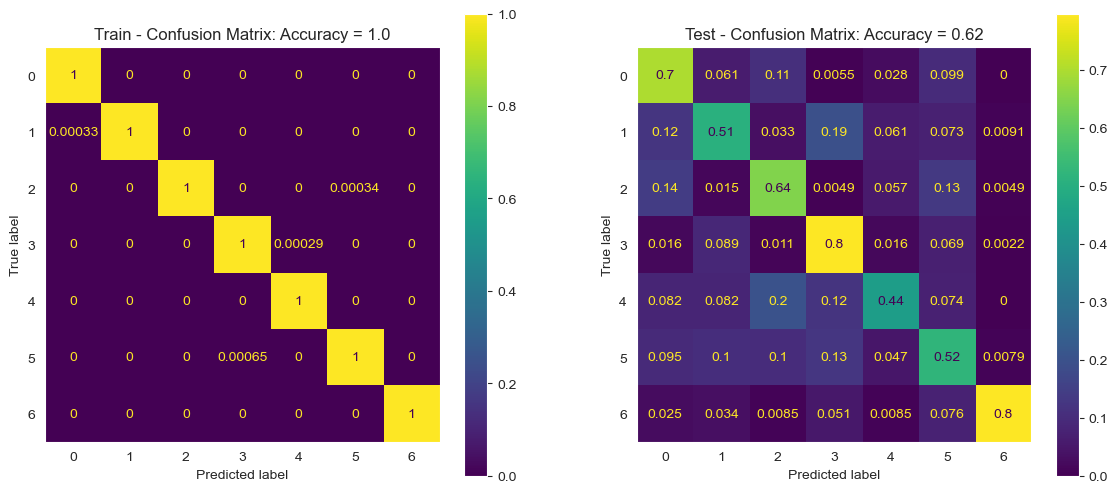

In [2]:
# load data from files
train_features_selected = lib.LoadCsv('train_features_selected')
train_labels = lib.LoadCsv('train_labels')
test_features_selected = lib.LoadCsv('test_features_selected')
test_labels = lib.LoadCsv('test_labels')

# Test selected features
report, score, model = lib.TestClassificationModel(train_features_selected,train_labels,test_features_selected,test_labels,3, paramC=1,kernelType='rbf',n_estimators=100,min_samples_split=6,random_state=1, plot=True)

In [3]:
def CrossValidation(model,numFold):
    trainAccArr = cross_val_score(
        model, 
        train_features_selected, 
        train_labels, 
        cv = StratifiedKFold(numFold, shuffle = True),
        n_jobs=-1)
    trainAcc = np.mean(trainAccArr)
    return trainAcc

def TestBestModel(model):
    model.fit(train_features_selected,train_labels)
    train_labels_pred = model.predict(train_features_selected)
    train_accuracy = model.score(train_features_selected,train_labels)
    test_labels_pred = model.predict(test_features_selected)
    test_accuracy = model.score(test_features_selected,test_labels)
    report = classification_report(test_labels,test_labels_pred)
    print(f'Prediction Train Accuracy: {train_accuracy*100:3.2f} %')
    print(f'Prediction Test Accuracy: {test_accuracy*100:3.2f} %')
    print(f'{report}')
    plt.figure(figsize=(14, 6))
    ax = plt.subplot(1,2,1)
    lConfMatTrainData = {'vY': train_labels, 'vYPred': train_labels_pred, 'hA': ax, 'dScore': {'Accuracy': train_accuracy}, 'titleStr': 'Train - Confusion Matrix'}
    lib.PlotConfusionMatrix(**lConfMatTrainData)
    ax = plt.subplot(1,2,2)
    lConfMatTestData = {'vY': test_labels, 'vYPred': test_labels_pred, 'hA': ax, 'dScore': {'Accuracy': test_accuracy}, 'titleStr': 'Test - Confusion Matrix'}
    lib.PlotConfusionMatrix(**lConfMatTestData)
    plt.show()

### KNN

In [5]:
from sklearn.neighbors import KNeighborsClassifier

study_name="Search_KNN_3"
study_KNN = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{study_name}.db",  # Specify the storage URL here.
    direction='maximize'
)

def oSearch_KNN(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 2, 100)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    p = trial.suggest_int("p", 1, 4)
    numFold = trial.suggest_int("numFold", 10, 20)
    trainAcc = CrossValidation(KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights,p=p,n_jobs=-1),numFold)
    return trainAcc

[I 2024-05-04 12:49:16,374] A new study created in RDB with name: Search_KNN_3


In [6]:
study_KNN.optimize(oSearch_KNN, n_trials=100)
print(f"Best score: {study_KNN.best_value}, Best Params: {study_KNN.best_params}")

# Test best model
TestBestModel(KNeighborsClassifier(n_neighbors=study_KNN.best_params['n_neighbors'],weights=study_KNN.best_params['weights'],p=study_KNN.best_params['p'],n_jobs=-1))

[I 2024-05-04 12:52:02,866] Trial 0 finished with value: 0.5320193089588804 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'p': 2, 'numFold': 14}. Best is trial 0 with value: 0.5320193089588804.
[I 2024-05-04 13:30:54,637] Trial 1 finished with value: 0.5252895640193352 and parameters: {'n_neighbors': 64, 'weights': 'distance', 'p': 4, 'numFold': 17}. Best is trial 0 with value: 0.5320193089588804.
[I 2024-05-04 13:32:53,327] Trial 2 finished with value: 0.5384446284379469 and parameters: {'n_neighbors': 68, 'weights': 'distance', 'p': 2, 'numFold': 14}. Best is trial 2 with value: 0.5384446284379469.
[I 2024-05-04 13:34:25,870] Trial 3 finished with value: 0.534948493050559 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'p': 1, 'numFold': 18}. Best is trial 2 with value: 0.5384446284379469.
